In [2]:
import os

print(os.environ['SPARK_HOME'])

/usr/share/spark


# Challenge 2 : Predicting Airline Delays
Every year approximately 20% of airline flights are delayed or cancelled, resulting in significant
costs to both travellers and airlines.
Objective
​
:
Build a predictive model capable of predicting airline 
​
departure
​
​
delay
​
​
from San Francisco CA
( SFO ) to the other airports in the dataset. 
​
Note
​
 it is possible to add weather information to
improve model accuracy

## Importing Libraries

In [122]:
import findspark
findspark.init()
import pyspark
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
from datetime import datetime
from pyspark.sql.functions import col, udf,to_date,unix_timestamp,from_unixtime,isnan, when, count
from pyspark.sql.types import DateType
from pyspark.sql.functions import date_format
from pyspark.sql.functions import year, month, dayofmonth, hour

## Create Spark Session

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .master("spark://data1p:7077") \
    .appName("Final-Assignment-Group3-AirlineDelays") \
    .getOrCreate()

## Load Flights Data

In [5]:
dataset_path="/data/shared/spark/challenge_2/"

In [6]:
# Read in all available data files into a data frame
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("file://"+dataset_path+"On_Time*.csv") 

In [13]:
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- FlightDate: timestamp (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- AirlineID: integer (nullable = true)
 |-- Carrier: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- OriginAirportSeqID: integer (nullable = true)
 |-- OriginCityMarketID: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- OriginStateFips: integer (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- OriginWac: integer (nullable = true)
 |-- DestAirportID: integer (nullable = true)
 |-- DestAirportSeqID: integer (nullable = true)
 |-- DestCityMarketID: integer (nu

In [12]:
df.count()

27365586

In [123]:
df=df.select("Year","Quarter","Month","DayofMonth","DayOfWeek","UniqueCarrier","AirlineID","Carrier","TailNum","FlightNum","OriginAirportID","OriginAirportSeqID","OriginCityMarketID","Origin","OriginCityName","OriginState","OriginStateFips","OriginStateName","OriginWac","DestAirportID","DestAirportSeqID","DestCityMarketID","Dest","DestCityName","DestState","DestStateFips","DestStateName","DestWac","CRSDepTime","DepTime","DepDelay","DepDelayMinutes","DepDel15","DepartureDelayGroups","DepTimeBlk","TaxiOut","WheelsOff","WheelsOn","TaxiIn","CRSArrTime","ArrTime","ArrDelay","ArrDelayMinutes","ArrDel15","ArrivalDelayGroups","ArrTimeBlk","Cancelled","CancellationCode","Diverted","CRSElapsedTime","ActualElapsedTime","AirTime","Flights","Distance","DistanceGroup")

## Filter Data for only San francisco

In [309]:
df_SFO=df.filter(df['origin']=='SFO')

## Data Inspection

In [126]:
df_SFO.where(col("DepDel15").isNull()).count()

9460

In [127]:
df_SFO.where(col("DepTime").isNull()).count()

9460

In [50]:
df_SFO.where(col("CancellationCode").isNull()).count()

546330

In [128]:
df_SFO.where(col("TailNum").isNull()).count()

4773

In [310]:
df_SFO=df_SFO.na.drop(subset=["DepDel15"])

In [311]:
df_SFO=df_SFO.drop(df_SFO.CancellationCode)

## Convert Data to Pandas For better Visulization

In [132]:
df_pd=df_SFO.toPandas()

### Check NaN Values

In [134]:
df_pd.columns[df_pd.isnull().any()].tolist()

['TailNum',
 'TaxiOut',
 'WheelsOff',
 'WheelsOn',
 'TaxiIn',
 'ArrTime',
 'ArrDelay',
 'ArrDelayMinutes',
 'ArrDel15',
 'ArrivalDelayGroups',
 'ActualElapsedTime',
 'AirTime']

### Plot Average Delayed Flights per Different Categories

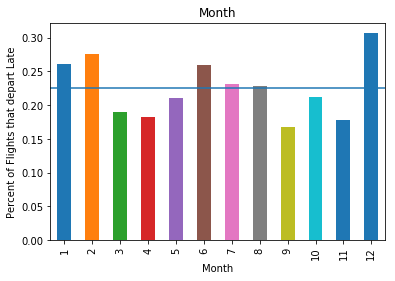

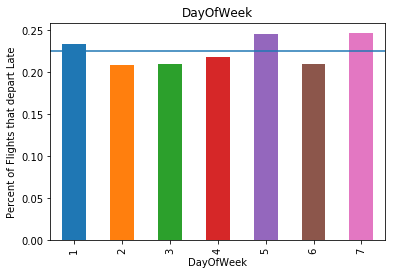

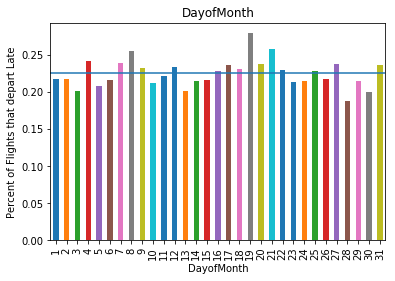

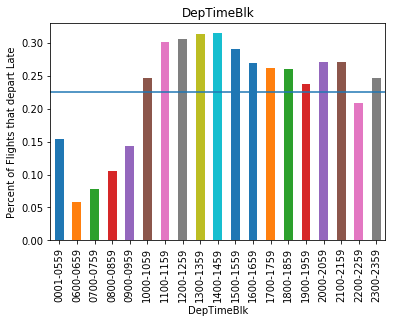

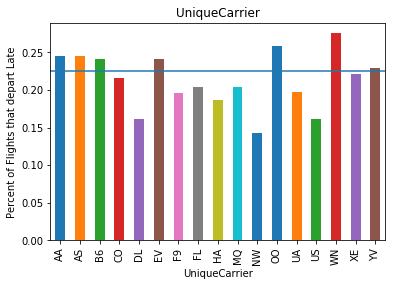

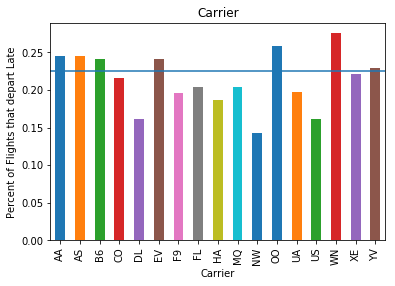

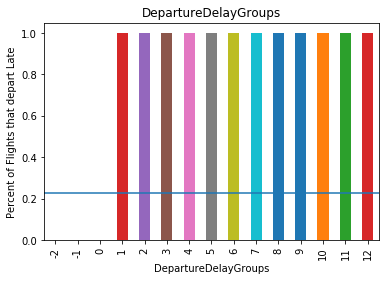

In [103]:
avgLate = np.sum(df_pd['DepDel15'])/len(df_pd['DepDel15'])
attributes = ['Month','DayOfWeek', 'DayofMonth', 'DepTimeBlk','UniqueCarrier','Carrier','DepartureDelayGroups']
for i,pred in enumerate(attributes):
    plt.figure(i, figsize=(15, 5))
    group = df_pd.groupby([pred], as_index=False).aggregate(np.mean)[[pred, 'DepDel15']]
    group.sort_values(by=pred, inplace=True)    
    group.plot.bar(x=pred, y='DepDel15')
    plt.axhline(y=avgLate, label='Average')
    plt.ylabel('Percent of Flights that depart Late')
    plt.title(pred)
    plt.legend().remove()


Exploratory analysis reveals:

(1) Delay changes substantially with Month e.g. lower delays in Autumn months   
(2) Not much variation within week and day of month    
(3) Higher delays for flights with departure and arrival time blocks from 3pm until midnight   
    (a) There seems to be a lag in the pattern for arrival time block   
    (b) Pattern starts with departure time block around 2pm and lasts until midnight    
    (c) Pattern starts with arrival time block around 4pm and lasts until 1am (with a lag of 1-2hrs)   
(5)Similar pattern is observed for arrival and departure delay groups    



### Check Multi-Colinearity 

In [106]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_pd["Unique_Carrier"] = le.fit_transform(df_pd["UniqueCarrier"])
UniqueCarrier = list(le.classes_)
df_pd["Carrier_Name"] = le.fit_transform(df_pd["Carrier"])
Carrier = list(le.classes_)

df_pd["Origin_Point"] = le.fit_transform(df_pd["Origin"])
Origin = list(le.classes_)
df_pd["Origin_CityName"] = le.fit_transform(df_pd["OriginCityName"])
OriginCityName = list(le.classes_)
df_pd["Origin_State"] = le.fit_transform(df_pd["OriginState"])
OriginState = list(le.classes_)
df_pd["OriginState_Name"] = le.fit_transform(df_pd["OriginStateName"])
OriginStateName = list(le.classes_)

df_pd["Destination"] = le.fit_transform(df_pd["Dest"])
Dest = list(le.classes_)
df_pd["Dest_CityName"] = le.fit_transform(df_pd["DestCityName"])
DestCityName = list(le.classes_)
df_pd["Dest_State"] = le.fit_transform(df_pd["DestState"])
DestState = list(le.classes_)
df_pd["Dest_StateName"] = le.fit_transform(df_pd["DestStateName"])
DestStateName = list(le.classes_)

df_pd["DepTime_Blk"] = le.fit_transform(df_pd["DepTimeBlk"])
DepTimeBlk = list(le.classes_)
df_pd["ArrTime_Blk"] = le.fit_transform(df_pd["ArrTimeBlk"])
ArrTimeBlk = list(le.classes_)

In [109]:
df_pd.drop(['UniqueCarrier','Carrier',
           'Origin','OriginCityName','OriginState','OriginStateName',
          'Dest','DestCityName','DestState','DestStateName',
          'DepTimeBlk','ArrTimeBlk'], axis=1, inplace=True)

In [110]:
rfDataOriginal = pd.DataFrame(df_pd)
Delay_YesNo = rfDataOriginal['DepDel15']
rfDataOriginal.drop(['DepDel15'], axis=1, inplace=True)#Removing target variable
print('Dimension reduced to:')
print(len(rfDataOriginal.columns))

Dimension reduced to:
41


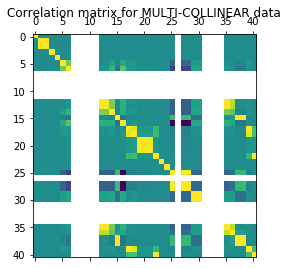

In [111]:
plt.matshow(rfDataOriginal.corr())
plt.title('Correlation matrix for MULTI-COLLINEAR data')
corr = rfDataOriginal.corr()

In [112]:
corr = rfDataOriginal.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr > 0.8)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices


[('Quarter', 'Month'),
 ('DestAirportID', 'DestAirportSeqID'),
 ('DestAirportID', 'Destination'),
 ('DestAirportSeqID', 'Destination'),
 ('DestStateFips', 'Dest_State'),
 ('DestStateFips', 'Dest_StateName'),
 ('CRSDepTime', 'DepTime'),
 ('CRSDepTime', 'DepTime_Blk'),
 ('DepTime', 'DepTime_Blk'),
 ('DepDelay', 'DepDelayMinutes'),
 ('DepDelay', 'DepartureDelayGroups'),
 ('DepDelayMinutes', 'DepartureDelayGroups'),
 ('CRSArrTime', 'ArrTime_Blk'),
 ('CRSElapsedTime', 'Distance'),
 ('CRSElapsedTime', 'DistanceGroup'),
 ('Distance', 'DistanceGroup'),
 ('Unique_Carrier', 'Carrier_Name'),
 ('Destination', 'Dest_CityName'),
 ('Dest_State', 'Dest_StateName')]

## Preprocessing Data

### Remove columns with NaN

In [312]:
df_SFO=df_SFO.drop('TailNum',
 'TaxiOut',
 'WheelsOff',
 'WheelsOn',
 'TaxiIn',
 'ArrTime',
 'ArrDelay',
 'ArrDelayMinutes',
 'ArrDel15',
 'ArrivalDelayGroups',
 'ActualElapsedTime',
 'AirTime')

### Remove Columns with Conflicts or Useless for analysis

In [313]:
df_SFO=df_SFO.drop('DepartureDelayGroups','ArrivalDelayGroups','OriginAirportSeqID','OriginCityMarketID', 'OriginStateFips', 'OriginWac', 
                     'DestAirportSeqID', 'DestCityMarketID', 'DestStateFips', 'DestWac',"DestAirportID","OriginAirportID"
                     'CRSDepTime', 'CRSElapsedTime', 'CRSArrTime','Carrier','OriginCityName', 'OriginStateName'
                      'DestCityName', 'DestState', 'DestStateName',"ArrTimeBlk","Diverted","DepDelayMinutes","ArrTimeBlk")

In [329]:
df_SFO=df_SFO.drop("OriginStateName","DepTimeBlk","DepDelay","DepTime","DestCityName","OriginState")

### Encode Labels for Categorical variables

In [331]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ["UniqueCarrier","Dest"]

stages = [] # stages in our Pipeline
for col in categoricalColumns:
  
  # Category Indexing with StringIndexer
  indexer = StringIndexer(inputCol=col, outputCol=col+"_index")
   
  # Use OneHotEncoder to convert categorical variables into binary SparseVectors
  encoder = OneHotEncoder(inputCol=col+"_index", outputCol=col+"_vector")
  
  # Add stages.  These are not run here, but will run all at once later on.
  stages += [indexer, encoder]

### Create vectors for modelling 

In [332]:
# Transform all numerical features into a vector using VectorAssembler
numericCols = ["Year", "Month", "DayofMonth", "DayOfWeek", "AirlineID", "FlightNum","CRSDepTime"]
assemblerInputs = [ col + "_vector" for col in categoricalColumns ] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [319]:
print(assemblerInputs)

['UniqueCarrier_vector', 'Dest_vector', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'AirlineID', 'FlightNum', 'CRSDepTime']


In [333]:
from pyspark.ml import Pipeline
# Create a Pipeline.
pipeline = Pipeline(stages=stages)

# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.

transformer = pipeline.fit(df_SFO)
transformed_df = transformer.transform(df_SFO)



In [337]:
from functools import reduce
oldColumns = transformed_df.schema.names
newColumns = ['Year',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'UniqueCarrier',
 'AirlineID',
 'FlightNum',
 'OriginAirportID',
 'Origin',
 'Dest',
 'CRSDepTime',
 'label',
 'Cancelled',
 'Flights',
 'Distance',
 'DistanceGroup',
 'UniqueCarrier_index',
 'UniqueCarrier_vector',
 'Dest_index',
 'Dest_vector',
 'features']

transformed_df = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), transformed_df)
transformed_df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- AirlineID: integer (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- Cancelled: double (nullable = true)
 |-- Flights: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DistanceGroup: integer (nullable = true)
 |-- UniqueCarrier_index: double (nullable = true)
 |-- UniqueCarrier_vector: vector (nullable = true)
 |-- Dest_index: double (nullable = true)
 |-- Dest_vector: vector (nullable = true)
 |-- features: vector (nullable = true)

+----+-------+-----+----------+---------+-------------+---------+----

In [338]:
# Keep relevant columns
selection = ["features", "label"] 
dataset = transformed_df.select(selection)

In [275]:
dataset.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(23,[2,16,17,18,1...|  1.0|
|(23,[2,16,17,18,1...|  1.0|
|(23,[2,16,17,18,1...|  1.0|
|(23,[2,16,17,18,1...|  1.0|
|(23,[2,16,17,18,1...|  0.0|
|(23,[2,16,17,18,1...|  0.0|
|(23,[2,16,17,18,1...|  0.0|
|(23,[2,16,17,18,1...|  0.0|
|(23,[2,16,17,18,1...|  0.0|
|(23,[2,16,17,18,1...|  1.0|
|(23,[2,16,17,18,1...|  0.0|
|(23,[2,16,17,18,1...|  0.0|
|(23,[2,16,17,18,1...|  1.0|
|(23,[2,16,17,18,1...|  0.0|
|(23,[2,16,17,18,1...|  1.0|
|(23,[2,16,17,18,1...|  0.0|
|(23,[2,16,17,18,1...|  0.0|
|(23,[2,16,17,18,1...|  1.0|
|(23,[2,16,17,18,1...|  0.0|
|(23,[2,16,17,18,1...|  0.0|
+--------------------+-----+
only showing top 20 rows



### Split dataset for Cross-Validation 

In [339]:


### Randomly split data into training (70%) and test (30%) sets. set seed for reproducibility
(train_data, test_data) = dataset.randomSplit([0.7, 0.3], seed = 100)
print('Training records : %d' % train_data.count())
print('Test records : %d ' % test_data.count())
train_data.cache()



Training records : 383408
Test records : 163135 


DataFrame[features: vector, label: double]

## Predictive Models

### Logistic Regression

In [341]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
model = lr.fit(train_data)

In [342]:
predictions = model.transform(test_data)

In [343]:
predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(105,[2,16,98,99,...|  0.0|[1.23629173570359...|[0.77491787767129...|       0.0|
|(105,[2,16,98,99,...|  0.0|[1.23678974244991...|[0.77500472819535...|       0.0|
|(105,[2,16,98,99,...|  1.0|[1.23547588051888...|[0.77477554416246...|       0.0|
|(105,[2,16,98,99,...|  0.0|[1.23474020724658...|[0.77464714440369...|       0.0|
|(105,[2,16,98,99,...|  0.0|[1.23468569258048...|[0.77463762769340...|       0.0|
|(105,[2,16,98,99,...|  0.0|[1.23585445695679...|[0.77484159827330...|       0.0|
|(105,[2,16,98,99,...|  0.0|[1.23668071311771...|[0.77498571591904...|       0.0|
|(105,[2,16,98,99,...|  0.0|[1.23463117791438...|[0.77462811069814...|       0.0|
|(105,[2,16,98,99,...|  0.0|[1.23662619845161...|[0.77497620935336...|       0.0|
|(105,[2,16,98,9

In [344]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
score = evaluator.evaluate(predictions)
print('Score is : %03f' % score )

Score is : 0.592069


### Random Forest

In [345]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from time import *

start_time = time()



labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(dataset)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(dataset)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

print(rfModel)  # summary only

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|           0.0|  0.0|(105,[2,16,98,99,...|
|           0.0|  0.0|(105,[2,16,98,99,...|
|           0.0|  1.0|(105,[2,16,98,99,...|
|           0.0|  0.0|(105,[2,16,98,99,...|
|           0.0|  0.0|(105,[2,16,98,99,...|
+--------------+-----+--------------------+
only showing top 5 rows

Test Error = 0.224864


IndexError: list index out of range

In [346]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Model accuracy = %g" % (accuracy))

Test Error = 0.224864
Model accuracy = 0.775136


## Import Weather Data

In [371]:
df2 = spark.read \
    .option("inferSchema", "true") \
    .csv("file://"+dataset_path+"weather_data_daily.csv")
    
features=[ "Site4","Date","Source", 
            "Max Temp","Avg Temp","HDDs", \
            "CDDs","Precipitation", \
            "Snowfall","Snow/Ice"]
#target=["median_value"]

fieldnames=features #+target

rawnames=df2.schema.names

# Create a small function
def updateColNames(df,oldnames,newnames):
    for i in range(len(newnames)):
        df=df.withColumnRenamed(oldnames[i], newnames[i])
    return df

df2=updateColNames(df2,rawnames,fieldnames)

df2.printSchema()

root
 |-- Site4: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Max Temp: integer (nullable = true)
 |-- Avg Temp: integer (nullable = true)
 |-- HDDs: double (nullable = true)
 |-- CDDs: double (nullable = true)
 |-- Precipitation: double (nullable = true)
 |-- Snowfall: double (nullable = true)
 |-- Snow/Ice: double (nullable = true)
 |-- _c10: double (nullable = true)



In [372]:
split_col = pyspark.sql.functions.split(df2['Date'], ' ')
df2 = df2.withColumn('Date', split_col.getItem(0))

In [349]:
df2.show()

+-----+---------+------+--------+--------+----+----+-------------+--------+--------+----+
|Site4|     Date|Source|Max Temp|Avg Temp|HDDs|CDDs|Precipitation|Snowfall|Snow/Ice|_c10|
+-----+---------+------+--------+--------+----+----+-------------+--------+--------+----+
| KSFO| 1/1/2007|  NCDC|      59|      40|49.5|15.5|          0.0|     0.0|     0.0|null|
| KSFO| 1/2/2007|  NCDC|      57|      43|50.0|15.0|          0.0|     0.0|     0.0|null|
| KSFO| 1/3/2007|  NCDC|      61|      43|52.0|13.0|          0.0|    0.01|     0.0|null|
| KSFO| 1/4/2007|  NCDC|      56|      45|50.5|14.5|          0.0|    0.12|     0.0|null|
| KSFO| 1/5/2007|  NCDC|      54|      43|48.5|16.5|          0.0|     0.0|     0.0|null|
| KSFO| 1/6/2007|  NCDC|      56|      37|46.5|18.5|          0.0|     0.0|     0.0|null|
| KSFO| 1/7/2007|  NCDC|      59|      41|50.0|15.0|          0.0|     0.0|     0.0|null|
| KSFO| 1/8/2007|  NCDC|      64|      44|54.0|11.0|          0.0|     0.0|     0.0|null|
| KSFO| 1/

In [350]:
df2.select([count(when(isnan(c), c)).alias(c) for c in df2.columns]).show()

+-----+----+------+--------+--------+----+----+-------------+--------+--------+----+
|Site4|Date|Source|Max Temp|Avg Temp|HDDs|CDDs|Precipitation|Snowfall|Snow/Ice|_c10|
+-----+----+------+--------+--------+----+----+-------------+--------+--------+----+
|    0|   0|     0|       0|       0|   0|   0|            0|       0|       0|   0|
+-----+----+------+--------+--------+----+----+-------------+--------+--------+----+



# Merge both Data Sets by date

In [373]:
df2 = df2.select('Date','Avg Temp','Precipitation','HDDs','CDDs','Snowfall','Snow/Ice', from_unixtime(unix_timestamp('Date', 'MM/dd/yyy')).alias('date2'))


In [374]:
split_col = pyspark.sql.functions.split(df2['date2'], ' ')
df2 = df2.withColumn('date2', split_col.getItem(0))
df2 = df2.select('date2','Avg Temp','Precipitation','Snowfall')
df2.show()

+----------+--------+-------------+--------+
|     date2|Avg Temp|Precipitation|Snowfall|
+----------+--------+-------------+--------+
|2007-01-01|      40|          0.0|     0.0|
|2007-01-02|      43|          0.0|     0.0|
|2007-01-03|      43|          0.0|    0.01|
|2007-01-04|      45|          0.0|    0.12|
|2007-01-05|      43|          0.0|     0.0|
|2007-01-06|      37|          0.0|     0.0|
|2007-01-07|      41|          0.0|     0.0|
|2007-01-08|      44|          0.0|     0.0|
|2007-01-09|      43|          0.0|     0.0|
|2007-01-10|      39|          0.0|     0.0|
|2007-01-11|      40|          0.0|     0.0|
|2007-01-12|      37|          0.0|     0.0|
|2007-01-13|      37|          0.0|     0.0|
|2007-01-14|      32|          0.0|     0.0|
|2007-01-15|      33|          0.0|     0.0|
|2007-01-16|      33|          0.0|    0.11|
|2007-01-17|      38|          0.0|    0.04|
|2007-01-18|      33|          0.0|     0.0|
|2007-01-19|      37|          0.0|     0.0|
|2007-01-2

In [375]:
df2=df2.select(year("date2").alias('year'),month("date2").alias('month'),dayofmonth("date2").alias('day'),"Avg Temp","Precipitation","Snowfall") 

In [376]:
df2.schema.names

['year', 'month', 'day', 'Avg Temp', 'Precipitation', 'Snowfall']

In [377]:
oldColumns = df2.schema.names
newColumns = ['w_year', 'w_month', 'w_day', 'Avg_Temp', 'Precipitation', 'Snowfall']
df2 = reduce(lambda df2, idx: df2.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), df2)
df2.printSchema()


root
 |-- w_year: integer (nullable = true)
 |-- w_month: integer (nullable = true)
 |-- w_day: integer (nullable = true)
 |-- Avg_Temp: integer (nullable = true)
 |-- Precipitation: double (nullable = true)
 |-- Snowfall: double (nullable = true)



In [378]:
df_SFO_Weather = df_SFO.join(df2, (df_SFO.Year == df2.w_year)&(df_SFO.Month == df2.w_month)&(df_SFO.DayofMonth == df2.w_day))
df_SFO_Weather.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- AirlineID: integer (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepDel15: double (nullable = true)
 |-- Cancelled: double (nullable = true)
 |-- Flights: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DistanceGroup: integer (nullable = true)
 |-- w_year: integer (nullable = true)
 |-- w_month: integer (nullable = true)
 |-- w_day: integer (nullable = true)
 |-- Avg_Temp: integer (nullable = true)
 |-- Precipitation: double (nullable = true)
 |-- Snowfall: double (nullable = true)



In [379]:
df_SFO_Weather=df_SFO_Weather.drop('w_year','w_month','w_day')

In [380]:
df_SFO_Weather.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- AirlineID: integer (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepDel15: double (nullable = true)
 |-- Cancelled: double (nullable = true)
 |-- Flights: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DistanceGroup: integer (nullable = true)
 |-- Avg_Temp: integer (nullable = true)
 |-- Precipitation: double (nullable = true)
 |-- Snowfall: double (nullable = true)



In [396]:
df_SFO_pd=df_SFO_Weather.toPandas()

In [413]:
temp=pd.DataFrame(df_SFO_pd[df_SFO_pd['DepDel15']>0].groupby('Avg_Temp').DepDel15.value_counts())

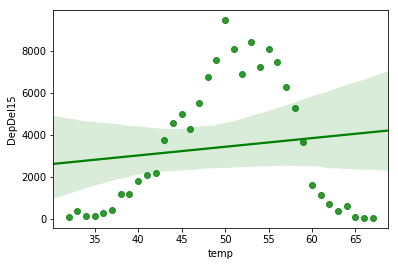

In [417]:
temp['temp']=temp.index.get_level_values('Avg_Temp')
sns.regplot(x=temp['temp'], y=temp['DepDel15'], color="g")

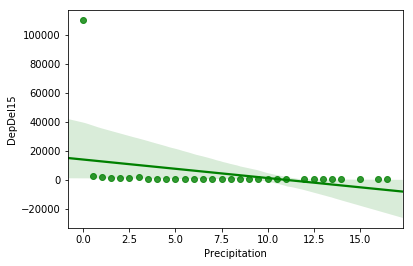

In [418]:
temp=pd.DataFrame(df_SFO_pd[df_SFO_pd['DepDel15']>0].groupby('Precipitation').DepDel15.value_counts())
temp['Precipitation']=temp.index.get_level_values('Precipitation')
sns.regplot(x=temp['Precipitation'], y=temp['DepDel15'], color="g")

# Run Random Forest with weather data

In [389]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ["UniqueCarrier","Dest"]

stages = [] # stages in our Pipeline
for col in categoricalColumns:
  
  # Category Indexing with StringIndexer
  indexer = StringIndexer(inputCol=col, outputCol=col+"_index")
   
  # Use OneHotEncoder to convert categorical variables into binary SparseVectors
  encoder = OneHotEncoder(inputCol=col+"_index", outputCol=col+"_vector")
  
  # Add stages.  These are not run here, but will run all at once later on.
  stages += [indexer, encoder]

In [390]:
# Transform all numerical features into a vector using VectorAssembler
numericCols = ["Year", "Month", "DayofMonth", "DayOfWeek", "AirlineID", "FlightNum","CRSDepTime","Avg_Temp","Precipitation"]
assemblerInputs = [ col + "_vector" for col in categoricalColumns ] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [391]:
from pyspark.ml import Pipeline
# Create a Pipeline.
pipeline = Pipeline(stages=stages)

# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.

transformer = pipeline.fit(df_SFO_Weather)
transformed_df = transformer.transform(df_SFO_Weather)


In [392]:
from functools import reduce
oldColumns = transformed_df.schema.names
newColumns = ['Year',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'UniqueCarrier',
 'AirlineID',
 'FlightNum',
 'OriginAirportID',
 'Origin',
 'Dest',
 'CRSDepTime',
 'label',
 'Cancelled',
 'Flights',
 'Distance',
 'DistanceGroup',
'Avg_Temp',
 'Precipitation',
 'Snowfall',
 'UniqueCarrier_index',
 'UniqueCarrier_vector',
 'Dest_index',
 'Dest_vector',
 'features']

transformed_df = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), transformed_df)
transformed_df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- AirlineID: integer (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- Cancelled: double (nullable = true)
 |-- Flights: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DistanceGroup: integer (nullable = true)
 |-- Avg_Temp: integer (nullable = true)
 |-- Precipitation: double (nullable = true)
 |-- Snowfall: double (nullable = true)
 |-- UniqueCarrier_index: double (nullable = true)
 |-- UniqueCarrier_vector: vector (nullable = true)
 |-- Dest_index: double (nullable = true)
 |-- Dest_vector: vector (n

In [393]:
# Keep relevant columns
selection = ["features", "label"] 
dataset = transformed_df.select(selection)

# Random Forest

In [394]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from time import *

start_time = time()



labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(dataset)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(dataset)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

print(rfModel)  # summary only

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|           0.0|  0.0|(107,[2,16,98,99,...|
|           0.0|  0.0|(107,[2,16,98,99,...|
|           0.0|  1.0|(107,[2,16,98,99,...|
|           0.0|  0.0|(107,[2,16,98,99,...|
|           0.0|  0.0|(107,[2,16,98,99,...|
+--------------+-----+--------------------+
only showing top 5 rows

Test Error = 0.225775
[StringIndexer_4082bd59dd3ef7795e54, VectorIndexer_46229d3b3c01085cf8df, RandomForestClassificationModel (uid=RandomForestClassifier_48cca2ed74bf702687d4) with 10 trees, IndexToString_416e97dcb1606d73d62a]


In [395]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Model accuracy = %g" % (accuracy))

Test Error = 0.225775
Model accuracy = 0.774225


In [ ]:
spark.stop()